# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

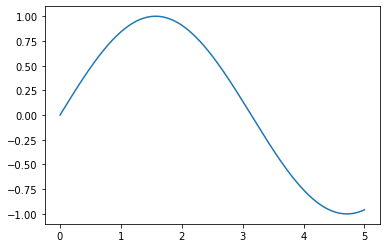

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

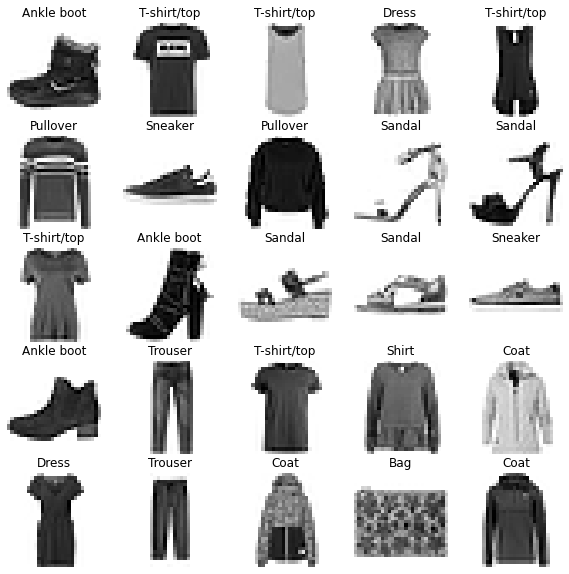

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Train on 60000 samples
Epoch 1/5


   32/60000 [..............................] - ETA: 11:52 - loss: 2.4660 - accuracy: 0.1250

  928/60000 [..............................] - ETA: 27s - loss: 1.3921 - accuracy: 0.5420  

 1856/60000 [..............................] - ETA: 15s - loss: 1.1271 - accuracy: 0.6315

 2784/60000 [>.............................] - ETA: 10s - loss: 0.9991 - accuracy: 0.6681

 3712/60000 [>.............................] - ETA: 8s - loss: 0.9221 - accuracy: 0.6913 

 4640/60000 [=>............................] - ETA: 7s - loss: 0.8780 - accuracy: 0.7073

 5504/60000 [=>............................] - ETA: 6s - loss: 0.8378 - accuracy: 0.7191

 6272/60000 [==>...........................] - ETA: 6s - loss: 0.8190 - accuracy: 0.7221

 7136/60000 [==>...........................] - ETA: 5s - loss: 0.7904 - accuracy: 0.7283

 8064/60000 [===>..........................] - ETA: 5s - loss: 0.7606 - accuracy: 0.7372

 8992/60000 [===>..........................] - ETA: 5s - loss: 0.7356 - accuracy: 0.7466

 9920/60000 [===>..........................] - ETA: 4s - loss: 0.7175 - accuracy: 0.7542

10848/60000 [====>.........................] - ETA: 4s - loss: 0.7010 - accuracy: 0.7592

11648/60000 [====>.........................] - ETA: 4s - loss: 0.6943 - accuracy: 0.7625

12576/60000 [=====>........................] - ETA: 4s - loss: 0.6830 - accuracy: 0.7658

13472/60000 [=====>........................] - ETA: 3s - loss: 0.6684 - accuracy: 0.7710

14400/60000 [======>.......................] - ETA: 3s - loss: 0.6585 - accuracy: 0.7737

15328/60000 [======>.......................] - ETA: 3s - loss: 0.6483 - accuracy: 0.7771

16256/60000 [=======>......................] - ETA: 3s - loss: 0.6393 - accuracy: 0.7801

17184/60000 [=======>......................] - ETA: 3s - loss: 0.6318 - accuracy: 0.7827

18112/60000 [========>.....................] - ETA: 3s - loss: 0.6246 - accuracy: 0.7843

19040/60000 [========>.....................] - ETA: 3s - loss: 0.6207 - accuracy: 0.7856

20000/60000 [=========>....................] - ETA: 2s - loss: 0.6151 - accuracy: 0.7878

20896/60000 [=========>....................] - ETA: 2s - loss: 0.6101 - accuracy: 0.7896

21824/60000 [=========>....................] - ETA: 2s - loss: 0.6016 - accuracy: 0.7930

22752/60000 [==========>...................] - ETA: 2s - loss: 0.5972 - accuracy: 0.7947

23680/60000 [==========>...................] - ETA: 2s - loss: 0.5914 - accuracy: 0.7968

24640/60000 [===========>..................] - ETA: 2s - loss: 0.5894 - accuracy: 0.7970

25568/60000 [===========>..................] - ETA: 2s - loss: 0.5858 - accuracy: 0.7984

26496/60000 [============>.................] - ETA: 2s - loss: 0.5818 - accuracy: 0.8000

27424/60000 [============>.................] - ETA: 2s - loss: 0.5768 - accuracy: 0.8014

28352/60000 [=============>................] - ETA: 2s - loss: 0.5732 - accuracy: 0.8030

29312/60000 [=============>................] - ETA: 2s - loss: 0.5702 - accuracy: 0.8040

30240/60000 [==============>...............] - ETA: 2s - loss: 0.5671 - accuracy: 0.8047

31168/60000 [==============>...............] - ETA: 1s - loss: 0.5636 - accuracy: 0.8056

32096/60000 [===============>..............] - ETA: 1s - loss: 0.5606 - accuracy: 0.8066

33024/60000 [===============>..............] - ETA: 1s - loss: 0.5576 - accuracy: 0.8076

33984/60000 [===============>..............] - ETA: 1s - loss: 0.5534 - accuracy: 0.8090

34912/60000 [================>.............] - ETA: 1s - loss: 0.5497 - accuracy: 0.8098

35872/60000 [================>.............] - ETA: 1s - loss: 0.5473 - accuracy: 0.8102

36800/60000 [=================>............] - ETA: 1s - loss: 0.5448 - accuracy: 0.8110

37728/60000 [=================>............] - ETA: 1s - loss: 0.5422 - accuracy: 0.8120

38656/60000 [==================>...........] - ETA: 1s - loss: 0.5381 - accuracy: 0.8133

39584/60000 [==================>...........] - ETA: 1s - loss: 0.5361 - accuracy: 0.8139

40512/60000 [===================>..........] - ETA: 1s - loss: 0.5343 - accuracy: 0.8145

41440/60000 [===================>..........] - ETA: 1s - loss: 0.5318 - accuracy: 0.8158

42400/60000 [====================>.........] - ETA: 1s - loss: 0.5298 - accuracy: 0.8166

43328/60000 [====================>.........] - ETA: 1s - loss: 0.5274 - accuracy: 0.8170

44288/60000 [=====================>........] - ETA: 1s - loss: 0.5250 - accuracy: 0.8179

45216/60000 [=====================>........] - ETA: 0s - loss: 0.5225 - accuracy: 0.8186

46176/60000 [======================>.......] - ETA: 0s - loss: 0.5211 - accuracy: 0.8191

47104/60000 [======================>.......] - ETA: 0s - loss: 0.5194 - accuracy: 0.8196

48032/60000 [=======================>......] - ETA: 0s - loss: 0.5172 - accuracy: 0.8199

48928/60000 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.8203

49856/60000 [=======================>......] - ETA: 0s - loss: 0.5147 - accuracy: 0.8209

50784/60000 [========================>.....] - ETA: 0s - loss: 0.5134 - accuracy: 0.8214

51712/60000 [========================>.....] - ETA: 0s - loss: 0.5115 - accuracy: 0.8221

52672/60000 [=========================>....] - ETA: 0s - loss: 0.5090 - accuracy: 0.8228

53600/60000 [=========================>....] - ETA: 0s - loss: 0.5071 - accuracy: 0.8235

54528/60000 [==========================>...] - ETA: 0s - loss: 0.5052 - accuracy: 0.8241

55456/60000 [==========================>...] - ETA: 0s - loss: 0.5035 - accuracy: 0.8246

56384/60000 [===========================>..] - ETA: 0s - loss: 0.5026 - accuracy: 0.8251

57312/60000 [===========================>..] - ETA: 0s - loss: 0.5007 - accuracy: 0.8257

58144/60000 [============================>.] - ETA: 0s - loss: 0.4990 - accuracy: 0.8262

59040/60000 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8268

59936/60000 [============================>.] - ETA: 0s - loss: 0.4957 - accuracy: 0.8271

60000/60000 [==============================] - 4s 61us/sample - loss: 0.4954 - accuracy: 0.8272


Epoch 2/5
   32/60000 [..............................] - ETA: 5s - loss: 0.2882 - accuracy: 0.8750

  960/60000 [..............................] - ETA: 3s - loss: 0.3889 - accuracy: 0.8552

 1888/60000 [..............................] - ETA: 3s - loss: 0.3968 - accuracy: 0.8607

 2816/60000 [>.............................] - ETA: 3s - loss: 0.4006 - accuracy: 0.8597

 3776/60000 [>.............................] - ETA: 3s - loss: 0.3953 - accuracy: 0.8620

 4704/60000 [=>............................] - ETA: 3s - loss: 0.4033 - accuracy: 0.8567

 5664/60000 [=>............................] - ETA: 2s - loss: 0.3992 - accuracy: 0.8577

 6592/60000 [==>...........................] - ETA: 2s - loss: 0.3985 - accuracy: 0.8585

 7456/60000 [==>...........................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8582

 8416/60000 [===>..........................] - ETA: 2s - loss: 0.3949 - accuracy: 0.8580

 9344/60000 [===>..........................] - ETA: 2s - loss: 0.3974 - accuracy: 0.8557

10272/60000 [====>.........................] - ETA: 2s - loss: 0.3987 - accuracy: 0.8559

11200/60000 [====>.........................] - ETA: 2s - loss: 0.4015 - accuracy: 0.8551

12096/60000 [=====>........................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8553

13024/60000 [=====>........................] - ETA: 2s - loss: 0.3970 - accuracy: 0.8570

13952/60000 [=====>........................] - ETA: 2s - loss: 0.3986 - accuracy: 0.8569

14816/60000 [======>.......................] - ETA: 2s - loss: 0.3965 - accuracy: 0.8579

15744/60000 [======>.......................] - ETA: 2s - loss: 0.3947 - accuracy: 0.8582

16640/60000 [=======>......................] - ETA: 2s - loss: 0.3949 - accuracy: 0.8580

17568/60000 [=======>......................] - ETA: 2s - loss: 0.3939 - accuracy: 0.8587

18496/60000 [========>.....................] - ETA: 2s - loss: 0.3907 - accuracy: 0.8595

19456/60000 [========>.....................] - ETA: 2s - loss: 0.3906 - accuracy: 0.8597

20384/60000 [=========>....................] - ETA: 2s - loss: 0.3909 - accuracy: 0.8591

21312/60000 [=========>....................] - ETA: 2s - loss: 0.3900 - accuracy: 0.8596

22272/60000 [==========>...................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8594

23232/60000 [==========>...................] - ETA: 2s - loss: 0.3902 - accuracy: 0.8595

24160/60000 [===========>..................] - ETA: 1s - loss: 0.3898 - accuracy: 0.8591

25088/60000 [===========>..................] - ETA: 1s - loss: 0.3891 - accuracy: 0.8594

25984/60000 [===========>..................] - ETA: 1s - loss: 0.3900 - accuracy: 0.8586

26912/60000 [============>.................] - ETA: 1s - loss: 0.3888 - accuracy: 0.8594

27840/60000 [============>.................] - ETA: 1s - loss: 0.3881 - accuracy: 0.8595

28768/60000 [=============>................] - ETA: 1s - loss: 0.3862 - accuracy: 0.8603

29696/60000 [=============>................] - ETA: 1s - loss: 0.3851 - accuracy: 0.8605

30624/60000 [==============>...............] - ETA: 1s - loss: 0.3836 - accuracy: 0.8610

31552/60000 [==============>...............] - ETA: 1s - loss: 0.3824 - accuracy: 0.8616

32480/60000 [===============>..............] - ETA: 1s - loss: 0.3818 - accuracy: 0.8618

33408/60000 [===============>..............] - ETA: 1s - loss: 0.3822 - accuracy: 0.8614

34272/60000 [================>.............] - ETA: 1s - loss: 0.3815 - accuracy: 0.8614

35200/60000 [================>.............] - ETA: 1s - loss: 0.3829 - accuracy: 0.8608

36128/60000 [=================>............] - ETA: 1s - loss: 0.3826 - accuracy: 0.8611

37056/60000 [=================>............] - ETA: 1s - loss: 0.3812 - accuracy: 0.8616

37984/60000 [=================>............] - ETA: 1s - loss: 0.3808 - accuracy: 0.8618

38912/60000 [==================>...........] - ETA: 1s - loss: 0.3798 - accuracy: 0.8621

39840/60000 [==================>...........] - ETA: 1s - loss: 0.3796 - accuracy: 0.8622

40768/60000 [===================>..........] - ETA: 1s - loss: 0.3792 - accuracy: 0.8624

41696/60000 [===================>..........] - ETA: 1s - loss: 0.3804 - accuracy: 0.8621

42624/60000 [====================>.........] - ETA: 0s - loss: 0.3808 - accuracy: 0.8617

43552/60000 [====================>.........] - ETA: 0s - loss: 0.3813 - accuracy: 0.8616

44320/60000 [=====================>........] - ETA: 0s - loss: 0.3807 - accuracy: 0.8619

45248/60000 [=====================>........] - ETA: 0s - loss: 0.3804 - accuracy: 0.8617

46176/60000 [======================>.......] - ETA: 0s - loss: 0.3794 - accuracy: 0.8620

47104/60000 [======================>.......] - ETA: 0s - loss: 0.3785 - accuracy: 0.8621

48032/60000 [=======================>......] - ETA: 0s - loss: 0.3776 - accuracy: 0.8624

48832/60000 [=======================>......] - ETA: 0s - loss: 0.3773 - accuracy: 0.8628

49760/60000 [=======================>......] - ETA: 0s - loss: 0.3774 - accuracy: 0.8627

50720/60000 [========================>.....] - ETA: 0s - loss: 0.3760 - accuracy: 0.8633

51648/60000 [========================>.....] - ETA: 0s - loss: 0.3750 - accuracy: 0.8637

52544/60000 [=========================>....] - ETA: 0s - loss: 0.3749 - accuracy: 0.8638

53472/60000 [=========================>....] - ETA: 0s - loss: 0.3745 - accuracy: 0.8639

54400/60000 [==========================>...] - ETA: 0s - loss: 0.3738 - accuracy: 0.8641

55328/60000 [==========================>...] - ETA: 0s - loss: 0.3737 - accuracy: 0.8644

56256/60000 [===========================>..] - ETA: 0s - loss: 0.3737 - accuracy: 0.8643

57184/60000 [===========================>..] - ETA: 0s - loss: 0.3731 - accuracy: 0.8645

58112/60000 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8645

59040/60000 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8646

59968/60000 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8648

60000/60000 [==============================] - 3s 55us/sample - loss: 0.3722 - accuracy: 0.8648


Epoch 3/5
   32/60000 [..............................] - ETA: 4s - loss: 0.4063 - accuracy: 0.8750

  960/60000 [..............................] - ETA: 3s - loss: 0.3460 - accuracy: 0.8740

 1888/60000 [..............................] - ETA: 3s - loss: 0.3403 - accuracy: 0.8766

 2816/60000 [>.............................] - ETA: 3s - loss: 0.3421 - accuracy: 0.8754

 3616/60000 [>.............................] - ETA: 3s - loss: 0.3502 - accuracy: 0.8750

 4544/60000 [=>............................] - ETA: 3s - loss: 0.3448 - accuracy: 0.8776

 5472/60000 [=>............................] - ETA: 3s - loss: 0.3451 - accuracy: 0.8772

 6432/60000 [==>...........................] - ETA: 2s - loss: 0.3403 - accuracy: 0.8786

 7360/60000 [==>...........................] - ETA: 2s - loss: 0.3395 - accuracy: 0.8783

 8288/60000 [===>..........................] - ETA: 2s - loss: 0.3448 - accuracy: 0.8769

 9216/60000 [===>..........................] - ETA: 2s - loss: 0.3413 - accuracy: 0.8773

10144/60000 [====>.........................] - ETA: 2s - loss: 0.3387 - accuracy: 0.8776

11072/60000 [====>.........................] - ETA: 2s - loss: 0.3381 - accuracy: 0.8782

12000/60000 [=====>........................] - ETA: 2s - loss: 0.3386 - accuracy: 0.8787

12960/60000 [=====>........................] - ETA: 2s - loss: 0.3368 - accuracy: 0.8790

13888/60000 [=====>........................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8795

14816/60000 [======>.......................] - ETA: 2s - loss: 0.3351 - accuracy: 0.8792

15744/60000 [======>.......................] - ETA: 2s - loss: 0.3359 - accuracy: 0.8779

16672/60000 [=======>......................] - ETA: 2s - loss: 0.3359 - accuracy: 0.8782

17440/60000 [=======>......................] - ETA: 2s - loss: 0.3340 - accuracy: 0.8788

18400/60000 [========>.....................] - ETA: 2s - loss: 0.3355 - accuracy: 0.8786

19360/60000 [========>.....................] - ETA: 2s - loss: 0.3371 - accuracy: 0.8775

20320/60000 [=========>....................] - ETA: 2s - loss: 0.3397 - accuracy: 0.8767

21248/60000 [=========>....................] - ETA: 2s - loss: 0.3382 - accuracy: 0.8771

22208/60000 [==========>...................] - ETA: 2s - loss: 0.3367 - accuracy: 0.8775

23168/60000 [==========>...................] - ETA: 2s - loss: 0.3358 - accuracy: 0.8780

24096/60000 [===========>..................] - ETA: 1s - loss: 0.3368 - accuracy: 0.8775

25024/60000 [===========>..................] - ETA: 1s - loss: 0.3370 - accuracy: 0.8774

25984/60000 [===========>..................] - ETA: 1s - loss: 0.3362 - accuracy: 0.8777

26912/60000 [============>.................] - ETA: 1s - loss: 0.3361 - accuracy: 0.8778

27872/60000 [============>.................] - ETA: 1s - loss: 0.3362 - accuracy: 0.8784

28800/60000 [=============>................] - ETA: 1s - loss: 0.3359 - accuracy: 0.8786

29728/60000 [=============>................] - ETA: 1s - loss: 0.3361 - accuracy: 0.8785

30624/60000 [==============>...............] - ETA: 1s - loss: 0.3359 - accuracy: 0.8788

31552/60000 [==============>...............] - ETA: 1s - loss: 0.3346 - accuracy: 0.8792

32480/60000 [===============>..............] - ETA: 1s - loss: 0.3347 - accuracy: 0.8792

33408/60000 [===============>..............] - ETA: 1s - loss: 0.3332 - accuracy: 0.8797

34336/60000 [================>.............] - ETA: 1s - loss: 0.3332 - accuracy: 0.8795

35264/60000 [================>.............] - ETA: 1s - loss: 0.3334 - accuracy: 0.8795

36224/60000 [=================>............] - ETA: 1s - loss: 0.3324 - accuracy: 0.8799

37184/60000 [=================>............] - ETA: 1s - loss: 0.3316 - accuracy: 0.8802

38112/60000 [==================>...........] - ETA: 1s - loss: 0.3310 - accuracy: 0.8804

39072/60000 [==================>...........] - ETA: 1s - loss: 0.3321 - accuracy: 0.8799

40000/60000 [===================>..........] - ETA: 1s - loss: 0.3325 - accuracy: 0.8797

40960/60000 [===================>..........] - ETA: 1s - loss: 0.3330 - accuracy: 0.8794

41888/60000 [===================>..........] - ETA: 0s - loss: 0.3335 - accuracy: 0.8791

42816/60000 [====================>.........] - ETA: 0s - loss: 0.3332 - accuracy: 0.8795

43744/60000 [====================>.........] - ETA: 0s - loss: 0.3328 - accuracy: 0.8794

44704/60000 [=====================>........] - ETA: 0s - loss: 0.3325 - accuracy: 0.8796

45632/60000 [=====================>........] - ETA: 0s - loss: 0.3338 - accuracy: 0.8792

46560/60000 [======================>.......] - ETA: 0s - loss: 0.3336 - accuracy: 0.8792

47488/60000 [======================>.......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8792

48416/60000 [=======================>......] - ETA: 0s - loss: 0.3337 - accuracy: 0.8792

49280/60000 [=======================>......] - ETA: 0s - loss: 0.3345 - accuracy: 0.8790

50208/60000 [========================>.....] - ETA: 0s - loss: 0.3353 - accuracy: 0.8786

51136/60000 [========================>.....] - ETA: 0s - loss: 0.3349 - accuracy: 0.8785

52064/60000 [=========================>....] - ETA: 0s - loss: 0.3346 - accuracy: 0.8787

52992/60000 [=========================>....] - ETA: 0s - loss: 0.3353 - accuracy: 0.8783

53920/60000 [=========================>....] - ETA: 0s - loss: 0.3352 - accuracy: 0.8782

54880/60000 [==========================>...] - ETA: 0s - loss: 0.3357 - accuracy: 0.8780

55840/60000 [==========================>...] - ETA: 0s - loss: 0.3350 - accuracy: 0.8782

56768/60000 [===========================>..] - ETA: 0s - loss: 0.3354 - accuracy: 0.8783

57696/60000 [===========================>..] - ETA: 0s - loss: 0.3350 - accuracy: 0.8783

58624/60000 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8786

59552/60000 [============================>.] - ETA: 0s - loss: 0.3347 - accuracy: 0.8783

60000/60000 [==============================] - 3s 55us/sample - loss: 0.3348 - accuracy: 0.8783


Epoch 4/5
   32/60000 [..............................] - ETA: 4s - loss: 0.3404 - accuracy: 0.8438

  992/60000 [..............................] - ETA: 3s - loss: 0.2762 - accuracy: 0.9032

 1952/60000 [..............................] - ETA: 3s - loss: 0.2974 - accuracy: 0.8955

 2912/60000 [>.............................] - ETA: 3s - loss: 0.3083 - accuracy: 0.8942

 3840/60000 [>.............................] - ETA: 3s - loss: 0.3105 - accuracy: 0.8917

 4800/60000 [=>............................] - ETA: 2s - loss: 0.3199 - accuracy: 0.8858

 5760/60000 [=>............................] - ETA: 2s - loss: 0.3236 - accuracy: 0.8839

 6720/60000 [==>...........................] - ETA: 2s - loss: 0.3194 - accuracy: 0.8853

 7648/60000 [==>...........................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8866

 8544/60000 [===>..........................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8858

 9504/60000 [===>..........................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8869

10432/60000 [====>.........................] - ETA: 2s - loss: 0.3105 - accuracy: 0.8884

11360/60000 [====>.........................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8892

12288/60000 [=====>........................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8888

13216/60000 [=====>........................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8886

14144/60000 [======>.......................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8874

15072/60000 [======>.......................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8876

16000/60000 [=======>......................] - ETA: 2s - loss: 0.3068 - accuracy: 0.8881

16928/60000 [=======>......................] - ETA: 2s - loss: 0.3074 - accuracy: 0.8885

17856/60000 [=======>......................] - ETA: 2s - loss: 0.3078 - accuracy: 0.8880

18784/60000 [========>.....................] - ETA: 2s - loss: 0.3093 - accuracy: 0.8875

19712/60000 [========>.....................] - ETA: 2s - loss: 0.3083 - accuracy: 0.8877

20640/60000 [=========>....................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8878

21568/60000 [=========>....................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8882

22496/60000 [==========>...................] - ETA: 2s - loss: 0.3051 - accuracy: 0.8886

23456/60000 [==========>...................] - ETA: 1s - loss: 0.3051 - accuracy: 0.8884

24416/60000 [===========>..................] - ETA: 1s - loss: 0.3058 - accuracy: 0.8877

25344/60000 [===========>..................] - ETA: 1s - loss: 0.3066 - accuracy: 0.8873

26272/60000 [============>.................] - ETA: 1s - loss: 0.3066 - accuracy: 0.8879

27104/60000 [============>.................] - ETA: 1s - loss: 0.3056 - accuracy: 0.8880

28000/60000 [=============>................] - ETA: 1s - loss: 0.3074 - accuracy: 0.8873

28928/60000 [=============>................] - ETA: 1s - loss: 0.3064 - accuracy: 0.8877

29856/60000 [=============>................] - ETA: 1s - loss: 0.3067 - accuracy: 0.8875

30816/60000 [==============>...............] - ETA: 1s - loss: 0.3060 - accuracy: 0.8880

31744/60000 [==============>...............] - ETA: 1s - loss: 0.3059 - accuracy: 0.8877

32672/60000 [===============>..............] - ETA: 1s - loss: 0.3066 - accuracy: 0.8874

33600/60000 [===============>..............] - ETA: 1s - loss: 0.3080 - accuracy: 0.8872

34560/60000 [================>.............] - ETA: 1s - loss: 0.3077 - accuracy: 0.8874

35520/60000 [================>.............] - ETA: 1s - loss: 0.3079 - accuracy: 0.8871

36448/60000 [=================>............] - ETA: 1s - loss: 0.3065 - accuracy: 0.8875

37344/60000 [=================>............] - ETA: 1s - loss: 0.3069 - accuracy: 0.8871

38272/60000 [==================>...........] - ETA: 1s - loss: 0.3062 - accuracy: 0.8873

39200/60000 [==================>...........] - ETA: 1s - loss: 0.3072 - accuracy: 0.8869

40128/60000 [===================>..........] - ETA: 1s - loss: 0.3078 - accuracy: 0.8868

41056/60000 [===================>..........] - ETA: 1s - loss: 0.3076 - accuracy: 0.8867

41984/60000 [===================>..........] - ETA: 0s - loss: 0.3077 - accuracy: 0.8870

42944/60000 [====================>.........] - ETA: 0s - loss: 0.3084 - accuracy: 0.8866

43872/60000 [====================>.........] - ETA: 0s - loss: 0.3089 - accuracy: 0.8864

44800/60000 [=====================>........] - ETA: 0s - loss: 0.3099 - accuracy: 0.8861

45728/60000 [=====================>........] - ETA: 0s - loss: 0.3101 - accuracy: 0.8863

46656/60000 [======================>.......] - ETA: 0s - loss: 0.3103 - accuracy: 0.8863

47584/60000 [======================>.......] - ETA: 0s - loss: 0.3107 - accuracy: 0.8860

48512/60000 [=======================>......] - ETA: 0s - loss: 0.3104 - accuracy: 0.8862

49440/60000 [=======================>......] - ETA: 0s - loss: 0.3098 - accuracy: 0.8864

50400/60000 [========================>.....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8861

51328/60000 [========================>.....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8865

52256/60000 [=========================>....] - ETA: 0s - loss: 0.3105 - accuracy: 0.8864

53184/60000 [=========================>....] - ETA: 0s - loss: 0.3103 - accuracy: 0.8864

54112/60000 [==========================>...] - ETA: 0s - loss: 0.3102 - accuracy: 0.8864

55040/60000 [==========================>...] - ETA: 0s - loss: 0.3102 - accuracy: 0.8863

55936/60000 [==========================>...] - ETA: 0s - loss: 0.3097 - accuracy: 0.8863

56864/60000 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8862

57792/60000 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8862

58752/60000 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8865

59680/60000 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8864

60000/60000 [==============================] - 3s 55us/sample - loss: 0.3094 - accuracy: 0.8865


Epoch 5/5
   32/60000 [..............................] - ETA: 4s - loss: 0.4358 - accuracy: 0.8438

  960/60000 [..............................] - ETA: 3s - loss: 0.2617 - accuracy: 0.9073

 1888/60000 [..............................] - ETA: 3s - loss: 0.2544 - accuracy: 0.9073

 2816/60000 [>.............................] - ETA: 3s - loss: 0.2590 - accuracy: 0.9041

 3680/60000 [>.............................] - ETA: 3s - loss: 0.2597 - accuracy: 0.9024

 4576/60000 [=>............................] - ETA: 3s - loss: 0.2632 - accuracy: 0.9023

 5472/60000 [=>............................] - ETA: 3s - loss: 0.2639 - accuracy: 0.9019

 6400/60000 [==>...........................] - ETA: 2s - loss: 0.2623 - accuracy: 0.9027

 7328/60000 [==>...........................] - ETA: 2s - loss: 0.2681 - accuracy: 0.9002

 8256/60000 [===>..........................] - ETA: 2s - loss: 0.2716 - accuracy: 0.8975

 9184/60000 [===>..........................] - ETA: 2s - loss: 0.2741 - accuracy: 0.8976

10112/60000 [====>.........................] - ETA: 2s - loss: 0.2796 - accuracy: 0.8953

11040/60000 [====>.........................] - ETA: 2s - loss: 0.2807 - accuracy: 0.8951

12000/60000 [=====>........................] - ETA: 2s - loss: 0.2800 - accuracy: 0.8951

12960/60000 [=====>........................] - ETA: 2s - loss: 0.2819 - accuracy: 0.8945

13888/60000 [=====>........................] - ETA: 2s - loss: 0.2833 - accuracy: 0.8945

14816/60000 [======>.......................] - ETA: 2s - loss: 0.2830 - accuracy: 0.8948

15744/60000 [======>.......................] - ETA: 2s - loss: 0.2823 - accuracy: 0.8951

16672/60000 [=======>......................] - ETA: 2s - loss: 0.2833 - accuracy: 0.8949

17568/60000 [=======>......................] - ETA: 2s - loss: 0.2840 - accuracy: 0.8945

18496/60000 [========>.....................] - ETA: 2s - loss: 0.2849 - accuracy: 0.8939

19424/60000 [========>.....................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8932

20384/60000 [=========>....................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8929

21248/60000 [=========>....................] - ETA: 2s - loss: 0.2882 - accuracy: 0.8938

22176/60000 [==========>...................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8941

23104/60000 [==========>...................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8934

24032/60000 [===========>..................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8929

24992/60000 [===========>..................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8927

25920/60000 [===========>..................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8924

26880/60000 [============>.................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8922

27808/60000 [============>.................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8922

28736/60000 [=============>................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8923

29664/60000 [=============>................] - ETA: 1s - loss: 0.2891 - accuracy: 0.8929

30624/60000 [==============>...............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8930

31552/60000 [==============>...............] - ETA: 1s - loss: 0.2890 - accuracy: 0.8929

32448/60000 [===============>..............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8926

33408/60000 [===============>..............] - ETA: 1s - loss: 0.2879 - accuracy: 0.8932

34336/60000 [================>.............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8929

35296/60000 [================>.............] - ETA: 1s - loss: 0.2872 - accuracy: 0.8934

36224/60000 [=================>............] - ETA: 1s - loss: 0.2882 - accuracy: 0.8931

37184/60000 [=================>............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8931

38144/60000 [==================>...........] - ETA: 1s - loss: 0.2893 - accuracy: 0.8926

39040/60000 [==================>...........] - ETA: 1s - loss: 0.2891 - accuracy: 0.8927

40000/60000 [===================>..........] - ETA: 1s - loss: 0.2890 - accuracy: 0.8928

40928/60000 [===================>..........] - ETA: 1s - loss: 0.2890 - accuracy: 0.8928

41856/60000 [===================>..........] - ETA: 0s - loss: 0.2895 - accuracy: 0.8927

42784/60000 [====================>.........] - ETA: 0s - loss: 0.2896 - accuracy: 0.8927

43712/60000 [====================>.........] - ETA: 0s - loss: 0.2905 - accuracy: 0.8922

44640/60000 [=====================>........] - ETA: 0s - loss: 0.2895 - accuracy: 0.8925

45568/60000 [=====================>........] - ETA: 0s - loss: 0.2893 - accuracy: 0.8928

46464/60000 [======================>.......] - ETA: 0s - loss: 0.2895 - accuracy: 0.8929

47392/60000 [======================>.......] - ETA: 0s - loss: 0.2893 - accuracy: 0.8930

48352/60000 [=======================>......] - ETA: 0s - loss: 0.2891 - accuracy: 0.8932

49280/60000 [=======================>......] - ETA: 0s - loss: 0.2894 - accuracy: 0.8932

50080/60000 [========================>.....] - ETA: 0s - loss: 0.2889 - accuracy: 0.8933

51008/60000 [========================>.....] - ETA: 0s - loss: 0.2892 - accuracy: 0.8933

51936/60000 [========================>.....] - ETA: 0s - loss: 0.2893 - accuracy: 0.8932

52864/60000 [=========================>....] - ETA: 0s - loss: 0.2896 - accuracy: 0.8932

53792/60000 [=========================>....] - ETA: 0s - loss: 0.2900 - accuracy: 0.8929

54720/60000 [==========================>...] - ETA: 0s - loss: 0.2903 - accuracy: 0.8926

55648/60000 [==========================>...] - ETA: 0s - loss: 0.2901 - accuracy: 0.8929

56576/60000 [===========================>..] - ETA: 0s - loss: 0.2896 - accuracy: 0.8931

57504/60000 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.8933

58464/60000 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8931

59392/60000 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8929

60000/60000 [==============================] - 3s 55us/sample - loss: 0.2896 - accuracy: 0.8930


Test accuracy: 0.8736


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Test accuracy: 0.8736


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 2:31 - loss: 2.7448 - probe_loss: 2.7448 - probe_accuracy: 0.0500

  680/60000 [..............................] - ETA: 8s - loss: 1.4896 - probe_loss: 1.4896 - probe_accuracy: 0.4721  

 1340/60000 [..............................] - ETA: 6s - loss: 1.2166 - probe_loss: 1.2166 - probe_accuracy: 0.5687

 2000/60000 [>.............................] - ETA: 5s - loss: 1.0519 - probe_loss: 1.0519 - probe_accuracy: 0.6270

 2660/60000 [>.............................] - ETA: 5s - loss: 0.9632 - probe_loss: 0.9632 - probe_accuracy: 0.6639

 3220/60000 [>.............................] - ETA: 5s - loss: 0.9261 - probe_loss: 0.9261 - probe_accuracy: 0.6804

 3860/60000 [>.............................] - ETA: 5s - loss: 0.8826 - probe_loss: 0.8826 - probe_accuracy: 0.6951

 4520/60000 [=>............................] - ETA: 4s - loss: 0.8495 - probe_loss: 0.8495 - probe_accuracy: 0.7046

 5140/60000 [=>............................] - ETA: 4s - loss: 0.8248 - probe_loss: 0.8248 - probe_accuracy: 0.7144

 5820/60000 [=>............................] - ETA: 4s - loss: 0.7907 - probe_loss: 0.7907 - probe_accuracy: 0.7254

 6460/60000 [==>...........................] - ETA: 4s - loss: 0.7731 - probe_loss: 0.7731 - probe_accuracy: 0.7328

 7000/60000 [==>...........................] - ETA: 4s - loss: 0.7543 - probe_loss: 0.7543 - probe_accuracy: 0.7383

 7660/60000 [==>...........................] - ETA: 4s - loss: 0.7334 - probe_loss: 0.7334 - probe_accuracy: 0.7453

 8320/60000 [===>..........................] - ETA: 4s - loss: 0.7178 - probe_loss: 0.7178 - probe_accuracy: 0.7510

 8980/60000 [===>..........................] - ETA: 4s - loss: 0.7038 - probe_loss: 0.7038 - probe_accuracy: 0.7549

 9640/60000 [===>..........................] - ETA: 4s - loss: 0.6929 - probe_loss: 0.6929 - probe_accuracy: 0.7584

10300/60000 [====>.........................] - ETA: 4s - loss: 0.6829 - probe_loss: 0.6829 - probe_accuracy: 0.7611

10960/60000 [====>.........................] - ETA: 4s - loss: 0.6778 - probe_loss: 0.6778 - probe_accuracy: 0.7630

11620/60000 [====>.........................] - ETA: 4s - loss: 0.6707 - probe_loss: 0.6707 - probe_accuracy: 0.7670

12280/60000 [=====>........................] - ETA: 3s - loss: 0.6620 - probe_loss: 0.6620 - probe_accuracy: 0.7697

12940/60000 [=====>........................] - ETA: 3s - loss: 0.6572 - probe_loss: 0.6572 - probe_accuracy: 0.7710

13620/60000 [=====>........................] - ETA: 3s - loss: 0.6488 - probe_loss: 0.6488 - probe_accuracy: 0.7736

14280/60000 [======>.......................] - ETA: 3s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7754

14940/60000 [======>.......................] - ETA: 3s - loss: 0.6394 - probe_loss: 0.6394 - probe_accuracy: 0.7768

15480/60000 [======>.......................] - ETA: 3s - loss: 0.6343 - probe_loss: 0.6343 - probe_accuracy: 0.7782

16140/60000 [=======>......................] - ETA: 3s - loss: 0.6311 - probe_loss: 0.6311 - probe_accuracy: 0.7799

16780/60000 [=======>......................] - ETA: 3s - loss: 0.6254 - probe_loss: 0.6254 - probe_accuracy: 0.7818

17440/60000 [=======>......................] - ETA: 3s - loss: 0.6199 - probe_loss: 0.6199 - probe_accuracy: 0.7833

18080/60000 [========>.....................] - ETA: 3s - loss: 0.6168 - probe_loss: 0.6168 - probe_accuracy: 0.7842

18740/60000 [========>.....................] - ETA: 3s - loss: 0.6112 - probe_loss: 0.6112 - probe_accuracy: 0.7859

19400/60000 [========>.....................] - ETA: 3s - loss: 0.6082 - probe_loss: 0.6082 - probe_accuracy: 0.7870

20040/60000 [=========>....................] - ETA: 3s - loss: 0.6025 - probe_loss: 0.6025 - probe_accuracy: 0.7885

20700/60000 [=========>....................] - ETA: 3s - loss: 0.5987 - probe_loss: 0.5987 - probe_accuracy: 0.7896

21360/60000 [=========>....................] - ETA: 3s - loss: 0.5935 - probe_loss: 0.5935 - probe_accuracy: 0.7912

22000/60000 [==========>...................] - ETA: 3s - loss: 0.5898 - probe_loss: 0.5898 - probe_accuracy: 0.7927

22660/60000 [==========>...................] - ETA: 3s - loss: 0.5868 - probe_loss: 0.5868 - probe_accuracy: 0.7937

23280/60000 [==========>...................] - ETA: 2s - loss: 0.5828 - probe_loss: 0.5828 - probe_accuracy: 0.7951

23940/60000 [==========>...................] - ETA: 2s - loss: 0.5792 - probe_loss: 0.5792 - probe_accuracy: 0.7961

24600/60000 [===========>..................] - ETA: 2s - loss: 0.5756 - probe_loss: 0.5756 - probe_accuracy: 0.7972

25260/60000 [===========>..................] - ETA: 2s - loss: 0.5717 - probe_loss: 0.5717 - probe_accuracy: 0.7984

25900/60000 [===========>..................] - ETA: 2s - loss: 0.5700 - probe_loss: 0.5700 - probe_accuracy: 0.7990

26560/60000 [============>.................] - ETA: 2s - loss: 0.5674 - probe_loss: 0.5674 - probe_accuracy: 0.7998

27220/60000 [============>.................] - ETA: 2s - loss: 0.5646 - probe_loss: 0.5646 - probe_accuracy: 0.8011

27900/60000 [============>.................] - ETA: 2s - loss: 0.5613 - probe_loss: 0.5613 - probe_accuracy: 0.8022

28560/60000 [=============>................] - ETA: 2s - loss: 0.5588 - probe_loss: 0.5588 - probe_accuracy: 0.8033

29220/60000 [=============>................] - ETA: 2s - loss: 0.5564 - probe_loss: 0.5564 - probe_accuracy: 0.8045

29860/60000 [=============>................] - ETA: 2s - loss: 0.5549 - probe_loss: 0.5549 - probe_accuracy: 0.8050

30520/60000 [==============>...............] - ETA: 2s - loss: 0.5537 - probe_loss: 0.5537 - probe_accuracy: 0.8054

31180/60000 [==============>...............] - ETA: 2s - loss: 0.5528 - probe_loss: 0.5528 - probe_accuracy: 0.8060

31840/60000 [==============>...............] - ETA: 2s - loss: 0.5507 - probe_loss: 0.5507 - probe_accuracy: 0.8064

32520/60000 [===============>..............] - ETA: 2s - loss: 0.5484 - probe_loss: 0.5484 - probe_accuracy: 0.8073

33180/60000 [===============>..............] - ETA: 2s - loss: 0.5451 - probe_loss: 0.5451 - probe_accuracy: 0.8087

33840/60000 [===============>..............] - ETA: 2s - loss: 0.5429 - probe_loss: 0.5429 - probe_accuracy: 0.8092

34500/60000 [================>.............] - ETA: 2s - loss: 0.5412 - probe_loss: 0.5412 - probe_accuracy: 0.8099

35140/60000 [================>.............] - ETA: 1s - loss: 0.5398 - probe_loss: 0.5398 - probe_accuracy: 0.8101

35800/60000 [================>.............] - ETA: 1s - loss: 0.5384 - probe_loss: 0.5384 - probe_accuracy: 0.8105

36440/60000 [=================>............] - ETA: 1s - loss: 0.5385 - probe_loss: 0.5385 - probe_accuracy: 0.8105

37100/60000 [=================>............] - ETA: 1s - loss: 0.5364 - probe_loss: 0.5364 - probe_accuracy: 0.8112

37760/60000 [=================>............] - ETA: 1s - loss: 0.5350 - probe_loss: 0.5350 - probe_accuracy: 0.8117

38420/60000 [==================>...........] - ETA: 1s - loss: 0.5316 - probe_loss: 0.5316 - probe_accuracy: 0.8129

39080/60000 [==================>...........] - ETA: 1s - loss: 0.5297 - probe_loss: 0.5297 - probe_accuracy: 0.8137

39740/60000 [==================>...........] - ETA: 1s - loss: 0.5285 - probe_loss: 0.5285 - probe_accuracy: 0.8141

40420/60000 [===================>..........] - ETA: 1s - loss: 0.5267 - probe_loss: 0.5267 - probe_accuracy: 0.8145

41080/60000 [===================>..........] - ETA: 1s - loss: 0.5252 - probe_loss: 0.5252 - probe_accuracy: 0.8148

41740/60000 [===================>..........] - ETA: 1s - loss: 0.5232 - probe_loss: 0.5232 - probe_accuracy: 0.8155

42400/60000 [====================>.........] - ETA: 1s - loss: 0.5214 - probe_loss: 0.5214 - probe_accuracy: 0.8162

43040/60000 [====================>.........] - ETA: 1s - loss: 0.5205 - probe_loss: 0.5205 - probe_accuracy: 0.8165

43700/60000 [====================>.........] - ETA: 1s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8172

44380/60000 [=====================>........] - ETA: 1s - loss: 0.5174 - probe_loss: 0.5174 - probe_accuracy: 0.8175

45040/60000 [=====================>........] - ETA: 1s - loss: 0.5159 - probe_loss: 0.5159 - probe_accuracy: 0.8180

45700/60000 [=====================>........] - ETA: 1s - loss: 0.5136 - probe_loss: 0.5136 - probe_accuracy: 0.8188

46380/60000 [======================>.......] - ETA: 1s - loss: 0.5125 - probe_loss: 0.5125 - probe_accuracy: 0.8190

47040/60000 [======================>.......] - ETA: 1s - loss: 0.5107 - probe_loss: 0.5107 - probe_accuracy: 0.8197

47660/60000 [======================>.......] - ETA: 0s - loss: 0.5094 - probe_loss: 0.5094 - probe_accuracy: 0.8200

48320/60000 [=======================>......] - ETA: 0s - loss: 0.5077 - probe_loss: 0.5077 - probe_accuracy: 0.8204

48960/60000 [=======================>......] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8210

49620/60000 [=======================>......] - ETA: 0s - loss: 0.5053 - probe_loss: 0.5053 - probe_accuracy: 0.8214

50280/60000 [========================>.....] - ETA: 0s - loss: 0.5046 - probe_loss: 0.5046 - probe_accuracy: 0.8215

50940/60000 [========================>.....] - ETA: 0s - loss: 0.5031 - probe_loss: 0.5031 - probe_accuracy: 0.8220

51600/60000 [========================>.....] - ETA: 0s - loss: 0.5018 - probe_loss: 0.5018 - probe_accuracy: 0.8224

52260/60000 [=========================>....] - ETA: 0s - loss: 0.5007 - probe_loss: 0.5007 - probe_accuracy: 0.8228

52920/60000 [=========================>....] - ETA: 0s - loss: 0.4997 - probe_loss: 0.4997 - probe_accuracy: 0.8233

53540/60000 [=========================>....] - ETA: 0s - loss: 0.4986 - probe_loss: 0.4986 - probe_accuracy: 0.8237

54200/60000 [==========================>...] - ETA: 0s - loss: 0.4972 - probe_loss: 0.4972 - probe_accuracy: 0.8240

54860/60000 [==========================>...] - ETA: 0s - loss: 0.4962 - probe_loss: 0.4962 - probe_accuracy: 0.8243

55520/60000 [==========================>...] - ETA: 0s - loss: 0.4956 - probe_loss: 0.4956 - probe_accuracy: 0.8246

56160/60000 [===========================>..] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8248

56820/60000 [===========================>..] - ETA: 0s - loss: 0.4943 - probe_loss: 0.4943 - probe_accuracy: 0.8250

57480/60000 [===========================>..] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8254

58140/60000 [============================>.] - ETA: 0s - loss: 0.4926 - probe_loss: 0.4926 - probe_accuracy: 0.8255

58700/60000 [============================>.] - ETA: 0s - loss: 0.4925 - probe_loss: 0.4925 - probe_accuracy: 0.8255

59360/60000 [============================>.] - ETA: 0s - loss: 0.4913 - probe_loss: 0.4913 - probe_accuracy: 0.8258

60000/60000 [==============================] - 5s 79us/sample - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8261


Epoch 2/5
   20/60000 [..............................] - ETA: 11s - loss: 0.3944 - probe_loss: 0.3944 - probe_accuracy: 0.8000

  680/60000 [..............................] - ETA: 4s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8662 

 1340/60000 [..............................] - ETA: 4s - loss: 0.3834 - probe_loss: 0.3834 - probe_accuracy: 0.8604

 1980/60000 [..............................] - ETA: 4s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8667

 2640/60000 [>.............................] - ETA: 4s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8644

 3300/60000 [>.............................] - ETA: 4s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8661

 3960/60000 [>.............................] - ETA: 4s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8654

 4620/60000 [=>............................] - ETA: 4s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8656

 5280/60000 [=>............................] - ETA: 4s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8687

 5940/60000 [=>............................] - ETA: 4s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8690

 6600/60000 [==>...........................] - ETA: 4s - loss: 0.3668 - probe_loss: 0.3668 - probe_accuracy: 0.8694

 7260/60000 [==>...........................] - ETA: 4s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8679

 7920/60000 [==>...........................] - ETA: 4s - loss: 0.3672 - probe_loss: 0.3672 - probe_accuracy: 0.8692

 8560/60000 [===>..........................] - ETA: 3s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8694

 9240/60000 [===>..........................] - ETA: 3s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8683

 9900/60000 [===>..........................] - ETA: 3s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8686

10560/60000 [====>.........................] - ETA: 3s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8689

11240/60000 [====>.........................] - ETA: 3s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8674

11900/60000 [====>.........................] - ETA: 3s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8671

12560/60000 [=====>........................] - ETA: 3s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8661

13220/60000 [=====>........................] - ETA: 3s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8666

13880/60000 [=====>........................] - ETA: 3s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8658

14540/60000 [======>.......................] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8660

15200/60000 [======>.......................] - ETA: 3s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8670

15840/60000 [======>.......................] - ETA: 3s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8665

16500/60000 [=======>......................] - ETA: 3s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8655

17160/60000 [=======>......................] - ETA: 3s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8645

17820/60000 [=======>......................] - ETA: 3s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8636

18480/60000 [========>.....................] - ETA: 3s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8639

19140/60000 [========>.....................] - ETA: 3s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8641

19800/60000 [========>.....................] - ETA: 3s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8642

20460/60000 [=========>....................] - ETA: 3s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8645

20880/60000 [=========>....................] - ETA: 3s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8646

21420/60000 [=========>....................] - ETA: 3s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8638

22100/60000 [==========>...................] - ETA: 2s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8639

22760/60000 [==========>...................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8635

23420/60000 [==========>...................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8637

24080/60000 [===========>..................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8632

24740/60000 [===========>..................] - ETA: 2s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8637

25420/60000 [===========>..................] - ETA: 2s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8636

26080/60000 [============>.................] - ETA: 2s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8643

26720/60000 [============>.................] - ETA: 2s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8646

27380/60000 [============>.................] - ETA: 2s - loss: 0.3779 - probe_loss: 0.3779 - probe_accuracy: 0.8642

28040/60000 [=============>................] - ETA: 2s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8650

28680/60000 [=============>................] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8655

29340/60000 [=============>................] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8658

29980/60000 [=============>................] - ETA: 2s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8659

30620/60000 [==============>...............] - ETA: 2s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8653

31280/60000 [==============>...............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8651

31940/60000 [==============>...............] - ETA: 2s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8653

32600/60000 [===============>..............] - ETA: 2s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8657

33280/60000 [===============>..............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8655

33940/60000 [===============>..............] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8654

34600/60000 [================>.............] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8655

35260/60000 [================>.............] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8659

35880/60000 [================>.............] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8657

36540/60000 [=================>............] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8653

37140/60000 [=================>............] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8654

37800/60000 [=================>............] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8657

38460/60000 [==================>...........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8659

39120/60000 [==================>...........] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8656

39780/60000 [==================>...........] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8660

40440/60000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8658

41100/60000 [===================>..........] - ETA: 1s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8658

41760/60000 [===================>..........] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8658

42420/60000 [====================>.........] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8658

43080/60000 [====================>.........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8659

43760/60000 [====================>.........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8661

44400/60000 [=====================>........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8659

45060/60000 [=====================>........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8661

45720/60000 [=====================>........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

46380/60000 [======================>.......] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8655

47040/60000 [======================>.......] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8657

47720/60000 [======================>.......] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8659

48380/60000 [=======================>......] - ETA: 0s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8659

49040/60000 [=======================>......] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8662

49700/60000 [=======================>......] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8663

50360/60000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8666

51040/60000 [========================>.....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8664

51720/60000 [========================>.....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8664

52380/60000 [=========================>....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8665

53060/60000 [=========================>....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8668

53720/60000 [=========================>....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8667

54380/60000 [==========================>...] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8667

55040/60000 [==========================>...] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8666

55700/60000 [==========================>...] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8666

56360/60000 [===========================>..] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8667

57020/60000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8670

57680/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8673

58340/60000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8672

59000/60000 [============================>.] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8671

59620/60000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8671

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8672


Epoch 3/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2510 - probe_loss: 0.2510 - probe_accuracy: 0.9500

  680/60000 [..............................] - ETA: 4s - loss: 0.3543 - probe_loss: 0.3543 - probe_accuracy: 0.8706 

 1340/60000 [..............................] - ETA: 4s - loss: 0.3422 - probe_loss: 0.3422 - probe_accuracy: 0.8746

 2000/60000 [>.............................] - ETA: 4s - loss: 0.3522 - probe_loss: 0.3522 - probe_accuracy: 0.8700

 2660/60000 [>.............................] - ETA: 4s - loss: 0.3592 - probe_loss: 0.3592 - probe_accuracy: 0.8662

 3300/60000 [>.............................] - ETA: 4s - loss: 0.3612 - probe_loss: 0.3612 - probe_accuracy: 0.8645

 3960/60000 [>.............................] - ETA: 4s - loss: 0.3562 - probe_loss: 0.3562 - probe_accuracy: 0.8664

 4620/60000 [=>............................] - ETA: 4s - loss: 0.3496 - probe_loss: 0.3496 - probe_accuracy: 0.8673

 5260/60000 [=>............................] - ETA: 4s - loss: 0.3481 - probe_loss: 0.3481 - probe_accuracy: 0.8709

 5920/60000 [=>............................] - ETA: 4s - loss: 0.3566 - probe_loss: 0.3566 - probe_accuracy: 0.8686

 6580/60000 [==>...........................] - ETA: 4s - loss: 0.3540 - probe_loss: 0.3540 - probe_accuracy: 0.8704

 7260/60000 [==>...........................] - ETA: 4s - loss: 0.3518 - probe_loss: 0.3518 - probe_accuracy: 0.8713

 7920/60000 [==>...........................] - ETA: 4s - loss: 0.3511 - probe_loss: 0.3511 - probe_accuracy: 0.8723

 8560/60000 [===>..........................] - ETA: 3s - loss: 0.3473 - probe_loss: 0.3473 - probe_accuracy: 0.8749

 9220/60000 [===>..........................] - ETA: 3s - loss: 0.3477 - probe_loss: 0.3477 - probe_accuracy: 0.8743

 9880/60000 [===>..........................] - ETA: 3s - loss: 0.3462 - probe_loss: 0.3462 - probe_accuracy: 0.8748

10520/60000 [====>.........................] - ETA: 3s - loss: 0.3438 - probe_loss: 0.3438 - probe_accuracy: 0.8756

11180/60000 [====>.........................] - ETA: 3s - loss: 0.3451 - probe_loss: 0.3451 - probe_accuracy: 0.8748

11860/60000 [====>.........................] - ETA: 3s - loss: 0.3428 - probe_loss: 0.3428 - probe_accuracy: 0.8755

12520/60000 [=====>........................] - ETA: 3s - loss: 0.3408 - probe_loss: 0.3408 - probe_accuracy: 0.8760

13180/60000 [=====>........................] - ETA: 3s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8756

13840/60000 [=====>........................] - ETA: 3s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8766

14520/60000 [======>.......................] - ETA: 3s - loss: 0.3408 - probe_loss: 0.3408 - probe_accuracy: 0.8753

15160/60000 [======>.......................] - ETA: 3s - loss: 0.3419 - probe_loss: 0.3419 - probe_accuracy: 0.8751

15780/60000 [======>.......................] - ETA: 3s - loss: 0.3414 - probe_loss: 0.3414 - probe_accuracy: 0.8755

16420/60000 [=======>......................] - ETA: 3s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8768

17080/60000 [=======>......................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8772

17740/60000 [=======>......................] - ETA: 3s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8771

18400/60000 [========>.....................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8775

19060/60000 [========>.....................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8773

19720/60000 [========>.....................] - ETA: 3s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8775

20380/60000 [=========>....................] - ETA: 3s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8769

21040/60000 [=========>....................] - ETA: 3s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8767

21680/60000 [=========>....................] - ETA: 2s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8759

22320/60000 [==========>...................] - ETA: 2s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8761

22920/60000 [==========>...................] - ETA: 2s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8764

23540/60000 [==========>...................] - ETA: 2s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770

24140/60000 [===========>..................] - ETA: 2s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8764

24800/60000 [===========>..................] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8771

25460/60000 [===========>..................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8772

26100/60000 [============>.................] - ETA: 2s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8769

26760/60000 [============>.................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8771

27420/60000 [============>.................] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8770

28080/60000 [=============>................] - ETA: 2s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8771

28720/60000 [=============>................] - ETA: 2s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8773

29360/60000 [=============>................] - ETA: 2s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8775

30020/60000 [==============>...............] - ETA: 2s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8774

30680/60000 [==============>...............] - ETA: 2s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8777

31340/60000 [==============>...............] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8783

32000/60000 [===============>..............] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8783

32660/60000 [===============>..............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8781

33320/60000 [===============>..............] - ETA: 2s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8783

33980/60000 [===============>..............] - ETA: 2s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8787

34640/60000 [================>.............] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8786

35300/60000 [================>.............] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8789

35940/60000 [================>.............] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8791

36620/60000 [=================>............] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

37280/60000 [=================>............] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8786

37940/60000 [=================>............] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8787

38600/60000 [==================>...........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8785

39260/60000 [==================>...........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8786

39920/60000 [==================>...........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8784

40580/60000 [===================>..........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8787

41240/60000 [===================>..........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8785

41880/60000 [===================>..........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8785

42520/60000 [====================>.........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8783

43180/60000 [====================>.........] - ETA: 1s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8788

43840/60000 [====================>.........] - ETA: 1s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

44500/60000 [=====================>........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8785

45160/60000 [=====================>........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8786

45820/60000 [=====================>........] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8785

46460/60000 [======================>.......] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8785

47120/60000 [======================>.......] - ETA: 1s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8785

47800/60000 [======================>.......] - ETA: 0s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8785

48460/60000 [=======================>......] - ETA: 0s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8784

49120/60000 [=======================>......] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

49780/60000 [=======================>......] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8782

50440/60000 [========================>.....] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8782

51100/60000 [========================>.....] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8783

51760/60000 [========================>.....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8781

52440/60000 [=========================>....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

53100/60000 [=========================>....] - ETA: 0s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8784

53760/60000 [=========================>....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

54420/60000 [==========================>...] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

55060/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8784

55720/60000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

56380/60000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

57040/60000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

57720/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8785

58400/60000 [============================>.] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8785

59060/60000 [============================>.] - ETA: 0s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8787

59700/60000 [============================>.] - ETA: 0s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8787

60000/60000 [==============================] - 5s 77us/sample - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8786


Epoch 4/5
   20/60000 [..............................] - ETA: 11s - loss: 0.4201 - probe_loss: 0.4201 - probe_accuracy: 0.9000

  700/60000 [..............................] - ETA: 4s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8886 

 1360/60000 [..............................] - ETA: 4s - loss: 0.2740 - probe_loss: 0.2740 - probe_accuracy: 0.9022

 2040/60000 [>.............................] - ETA: 4s - loss: 0.2761 - probe_loss: 0.2761 - probe_accuracy: 0.9005

 2700/60000 [>.............................] - ETA: 4s - loss: 0.2801 - probe_loss: 0.2801 - probe_accuracy: 0.8978

 3380/60000 [>.............................] - ETA: 4s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8923

 4060/60000 [=>............................] - ETA: 4s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8899

 4700/60000 [=>............................] - ETA: 4s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8883

 5380/60000 [=>............................] - ETA: 4s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8888

 6040/60000 [==>...........................] - ETA: 4s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8889

 6720/60000 [==>...........................] - ETA: 4s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8899

 7380/60000 [==>...........................] - ETA: 4s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8893

 8040/60000 [===>..........................] - ETA: 3s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8894

 8700/60000 [===>..........................] - ETA: 3s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8891

 9360/60000 [===>..........................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8887

10020/60000 [====>.........................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8883

10680/60000 [====>.........................] - ETA: 3s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8890

11340/60000 [====>.........................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8880

12000/60000 [=====>........................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8888

12660/60000 [=====>........................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8890

13300/60000 [=====>........................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8883

13980/60000 [=====>........................] - ETA: 3s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8891

14640/60000 [======>.......................] - ETA: 3s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8897

15300/60000 [======>.......................] - ETA: 3s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8884

15980/60000 [======>.......................] - ETA: 3s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8890

16640/60000 [=======>......................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8881

17300/60000 [=======>......................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8883

17960/60000 [=======>......................] - ETA: 3s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8889

18620/60000 [========>.....................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8886

19280/60000 [========>.....................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8886

19920/60000 [========>.....................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8878

20580/60000 [=========>....................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8876

21240/60000 [=========>....................] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8875

21880/60000 [=========>....................] - ETA: 2s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8868

22520/60000 [==========>...................] - ETA: 2s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8863

23180/60000 [==========>...................] - ETA: 2s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8871

23840/60000 [==========>...................] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8869

24500/60000 [===========>..................] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8869

25160/60000 [===========>..................] - ETA: 2s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8868

25820/60000 [===========>..................] - ETA: 2s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8876

26480/60000 [============>.................] - ETA: 2s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8872

27060/60000 [============>.................] - ETA: 2s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8868

27720/60000 [============>.................] - ETA: 2s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8868

28380/60000 [=============>................] - ETA: 2s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8862

29040/60000 [=============>................] - ETA: 2s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8858

29700/60000 [=============>................] - ETA: 2s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8862

30380/60000 [==============>...............] - ETA: 2s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8862

31040/60000 [==============>...............] - ETA: 2s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8861

31700/60000 [==============>...............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8861

32360/60000 [===============>..............] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8859

32940/60000 [===============>..............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8861

33600/60000 [===============>..............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8861

34260/60000 [================>.............] - ETA: 1s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8863

34900/60000 [================>.............] - ETA: 1s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8860

35560/60000 [================>.............] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8858

36220/60000 [=================>............] - ETA: 1s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8860

36880/60000 [=================>............] - ETA: 1s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8856

37540/60000 [=================>............] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8854

38200/60000 [==================>...........] - ETA: 1s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8855

38860/60000 [==================>...........] - ETA: 1s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8855

39520/60000 [==================>...........] - ETA: 1s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8857

40180/60000 [===================>..........] - ETA: 1s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8857

40840/60000 [===================>..........] - ETA: 1s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8854

41500/60000 [===================>..........] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8852

42160/60000 [====================>.........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8848

42820/60000 [====================>.........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

43480/60000 [====================>.........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8852

44160/60000 [=====================>........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8849

44820/60000 [=====================>........] - ETA: 1s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8845

45480/60000 [=====================>........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8845

46040/60000 [======================>.......] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8848

46700/60000 [======================>.......] - ETA: 1s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8848

47360/60000 [======================>.......] - ETA: 0s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8851

48000/60000 [=======================>......] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8852

48640/60000 [=======================>......] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8854

49300/60000 [=======================>......] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8854

49920/60000 [=======================>......] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8853

50540/60000 [========================>.....] - ETA: 0s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8851

51180/60000 [========================>.....] - ETA: 0s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8850

51840/60000 [========================>.....] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

52500/60000 [=========================>....] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

53160/60000 [=========================>....] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

53820/60000 [=========================>....] - ETA: 0s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8852

54480/60000 [==========================>...] - ETA: 0s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8851

55140/60000 [==========================>...] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8853

55820/60000 [==========================>...] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8851

56480/60000 [===========================>..] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8854

57140/60000 [===========================>..] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8853

57800/60000 [===========================>..] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8852

58460/60000 [============================>.] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8854

59100/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8855

59760/60000 [============================>.] - ETA: 0s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8856

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8856


Epoch 5/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2110 - probe_loss: 0.2110 - probe_accuracy: 0.9500

  680/60000 [..............................] - ETA: 4s - loss: 0.2846 - probe_loss: 0.2846 - probe_accuracy: 0.9074 

 1240/60000 [..............................] - ETA: 4s - loss: 0.2742 - probe_loss: 0.2742 - probe_accuracy: 0.9032

 1860/60000 [..............................] - ETA: 4s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.9022

 2500/60000 [>.............................] - ETA: 4s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.9028

 3180/60000 [>.............................] - ETA: 4s - loss: 0.2794 - probe_loss: 0.2794 - probe_accuracy: 0.9003

 3840/60000 [>.............................] - ETA: 4s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.8995

 4500/60000 [=>............................] - ETA: 4s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8991

 5160/60000 [=>............................] - ETA: 4s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8973

 5820/60000 [=>............................] - ETA: 4s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8988

 6480/60000 [==>...........................] - ETA: 4s - loss: 0.2842 - probe_loss: 0.2842 - probe_accuracy: 0.8998

 7140/60000 [==>...........................] - ETA: 4s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.9008

 7640/60000 [==>...........................] - ETA: 4s - loss: 0.2820 - probe_loss: 0.2820 - probe_accuracy: 0.9012

 8300/60000 [===>..........................] - ETA: 4s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8995

 8940/60000 [===>..........................] - ETA: 4s - loss: 0.2841 - probe_loss: 0.2841 - probe_accuracy: 0.8996

 9600/60000 [===>..........................] - ETA: 3s - loss: 0.2828 - probe_loss: 0.2828 - probe_accuracy: 0.9003

10260/60000 [====>.........................] - ETA: 3s - loss: 0.2833 - probe_loss: 0.2833 - probe_accuracy: 0.8997

10860/60000 [====>.........................] - ETA: 3s - loss: 0.2842 - probe_loss: 0.2842 - probe_accuracy: 0.8997

11520/60000 [====>.........................] - ETA: 3s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8997

12180/60000 [=====>........................] - ETA: 3s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8989

12860/60000 [=====>........................] - ETA: 3s - loss: 0.2852 - probe_loss: 0.2852 - probe_accuracy: 0.8986

13520/60000 [=====>........................] - ETA: 3s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8978

14140/60000 [======>.......................] - ETA: 3s - loss: 0.2842 - probe_loss: 0.2842 - probe_accuracy: 0.8983

14780/60000 [======>.......................] - ETA: 3s - loss: 0.2842 - probe_loss: 0.2842 - probe_accuracy: 0.8985

15440/60000 [======>.......................] - ETA: 3s - loss: 0.2836 - probe_loss: 0.2836 - probe_accuracy: 0.8985

16120/60000 [=======>......................] - ETA: 3s - loss: 0.2830 - probe_loss: 0.2830 - probe_accuracy: 0.8986

16780/60000 [=======>......................] - ETA: 3s - loss: 0.2836 - probe_loss: 0.2836 - probe_accuracy: 0.8982

17440/60000 [=======>......................] - ETA: 3s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8973

18100/60000 [========>.....................] - ETA: 3s - loss: 0.2845 - probe_loss: 0.2845 - probe_accuracy: 0.8970

18760/60000 [========>.....................] - ETA: 3s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8971

19420/60000 [========>.....................] - ETA: 3s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8973

20080/60000 [=========>....................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8966

20740/60000 [=========>....................] - ETA: 3s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8961

21400/60000 [=========>....................] - ETA: 3s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8956

22060/60000 [==========>...................] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8955

22720/60000 [==========>...................] - ETA: 2s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8959

23280/60000 [==========>...................] - ETA: 2s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8959

23940/60000 [==========>...................] - ETA: 2s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8952

24600/60000 [===========>..................] - ETA: 2s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8959

25240/60000 [===========>..................] - ETA: 2s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8961

25900/60000 [===========>..................] - ETA: 2s - loss: 0.2865 - probe_loss: 0.2865 - probe_accuracy: 0.8956

26560/60000 [============>.................] - ETA: 2s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8956

27200/60000 [============>.................] - ETA: 2s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8958

27840/60000 [============>.................] - ETA: 2s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8958

28500/60000 [=============>................] - ETA: 2s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8957

29160/60000 [=============>................] - ETA: 2s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8959

29820/60000 [=============>................] - ETA: 2s - loss: 0.2865 - probe_loss: 0.2865 - probe_accuracy: 0.8958

30380/60000 [==============>...............] - ETA: 2s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8957

31040/60000 [==============>...............] - ETA: 2s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8951

31700/60000 [==============>...............] - ETA: 2s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8951

32380/60000 [===============>..............] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8948

33060/60000 [===============>..............] - ETA: 2s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8947

33720/60000 [===============>..............] - ETA: 2s - loss: 0.2899 - probe_loss: 0.2899 - probe_accuracy: 0.8948

34360/60000 [================>.............] - ETA: 2s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8948

35020/60000 [================>.............] - ETA: 1s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8949

35700/60000 [================>.............] - ETA: 1s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8950

36360/60000 [=================>............] - ETA: 1s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8951

37020/60000 [=================>............] - ETA: 1s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8951

37680/60000 [=================>............] - ETA: 1s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8950

38320/60000 [==================>...........] - ETA: 1s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8950

38980/60000 [==================>...........] - ETA: 1s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8953

39640/60000 [==================>...........] - ETA: 1s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8953

40260/60000 [===================>..........] - ETA: 1s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8953

40920/60000 [===================>..........] - ETA: 1s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8952

41580/60000 [===================>..........] - ETA: 1s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8954

42240/60000 [====================>.........] - ETA: 1s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8955

42900/60000 [====================>.........] - ETA: 1s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8955

43560/60000 [====================>.........] - ETA: 1s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8958

44220/60000 [=====================>........] - ETA: 1s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8958

44880/60000 [=====================>........] - ETA: 1s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8958

45520/60000 [=====================>........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8955

46180/60000 [======================>.......] - ETA: 1s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8955

46840/60000 [======================>.......] - ETA: 1s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8954

47500/60000 [======================>.......] - ETA: 0s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8954

48160/60000 [=======================>......] - ETA: 0s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8949

48820/60000 [=======================>......] - ETA: 0s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8949

49460/60000 [=======================>......] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8947

50120/60000 [========================>.....] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8945

50780/60000 [========================>.....] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8943

51140/60000 [========================>.....] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8941

51680/60000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8943

52340/60000 [=========================>....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8942

52920/60000 [=========================>....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8943

53460/60000 [=========================>....] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8942

54140/60000 [==========================>...] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8941

54800/60000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8941

55480/60000 [==========================>...] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8942

56140/60000 [===========================>..] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8939

56800/60000 [===========================>..] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8940

57460/60000 [===========================>..] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8941

58120/60000 [============================>.] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8942

58780/60000 [============================>.] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8941

59440/60000 [============================>.] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8939

60000/60000 [==============================] - 5s 78us/sample - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8938


Test accuracy: 0.8746


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 3:09 - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  680/60000 [..............................] - ETA: 9s - loss: 1.2828 - probe_loss: 1.2828 - probe_accuracy: 0.5706  

 1340/60000 [..............................] - ETA: 7s - loss: 1.1280 - probe_loss: 1.1280 - probe_accuracy: 0.6224

 1980/60000 [..............................] - ETA: 6s - loss: 1.0118 - probe_loss: 1.0118 - probe_accuracy: 0.6606

 2620/60000 [>.............................] - ETA: 5s - loss: 0.9262 - probe_loss: 0.9262 - probe_accuracy: 0.6916

 3280/60000 [>.............................] - ETA: 5s - loss: 0.8837 - probe_loss: 0.8837 - probe_accuracy: 0.7049

 3940/60000 [>.............................] - ETA: 5s - loss: 0.8477 - probe_loss: 0.8477 - probe_accuracy: 0.7155

 4580/60000 [=>............................] - ETA: 5s - loss: 0.8130 - probe_loss: 0.8130 - probe_accuracy: 0.7271

 5240/60000 [=>............................] - ETA: 4s - loss: 0.7869 - probe_loss: 0.7869 - probe_accuracy: 0.7374

 5900/60000 [=>............................] - ETA: 4s - loss: 0.7608 - probe_loss: 0.7608 - probe_accuracy: 0.7453

 6560/60000 [==>...........................] - ETA: 4s - loss: 0.7463 - probe_loss: 0.7463 - probe_accuracy: 0.7497

 7220/60000 [==>...........................] - ETA: 4s - loss: 0.7321 - probe_loss: 0.7321 - probe_accuracy: 0.7539

 7880/60000 [==>...........................] - ETA: 4s - loss: 0.7177 - probe_loss: 0.7177 - probe_accuracy: 0.7576

 8540/60000 [===>..........................] - ETA: 4s - loss: 0.7040 - probe_loss: 0.7040 - probe_accuracy: 0.7622

 9180/60000 [===>..........................] - ETA: 4s - loss: 0.6919 - probe_loss: 0.6919 - probe_accuracy: 0.7658

 9840/60000 [===>..........................] - ETA: 4s - loss: 0.6868 - probe_loss: 0.6868 - probe_accuracy: 0.7669

10500/60000 [====>.........................] - ETA: 4s - loss: 0.6764 - probe_loss: 0.6764 - probe_accuracy: 0.7704

11160/60000 [====>.........................] - ETA: 4s - loss: 0.6662 - probe_loss: 0.6662 - probe_accuracy: 0.7738

11820/60000 [====>.........................] - ETA: 4s - loss: 0.6580 - probe_loss: 0.6580 - probe_accuracy: 0.7761

12480/60000 [=====>........................] - ETA: 3s - loss: 0.6513 - probe_loss: 0.6513 - probe_accuracy: 0.7776

13140/60000 [=====>........................] - ETA: 3s - loss: 0.6462 - probe_loss: 0.6462 - probe_accuracy: 0.7791

13780/60000 [=====>........................] - ETA: 3s - loss: 0.6402 - probe_loss: 0.6402 - probe_accuracy: 0.7808

14420/60000 [======>.......................] - ETA: 3s - loss: 0.6325 - probe_loss: 0.6325 - probe_accuracy: 0.7827

15080/60000 [======>.......................] - ETA: 3s - loss: 0.6255 - probe_loss: 0.6255 - probe_accuracy: 0.7847

15680/60000 [======>.......................] - ETA: 3s - loss: 0.6207 - probe_loss: 0.6207 - probe_accuracy: 0.7864

16340/60000 [=======>......................] - ETA: 3s - loss: 0.6144 - probe_loss: 0.6144 - probe_accuracy: 0.7883

17000/60000 [=======>......................] - ETA: 3s - loss: 0.6088 - probe_loss: 0.6088 - probe_accuracy: 0.7904

17660/60000 [=======>......................] - ETA: 3s - loss: 0.6012 - probe_loss: 0.6012 - probe_accuracy: 0.7931

18320/60000 [========>.....................] - ETA: 3s - loss: 0.5971 - probe_loss: 0.5971 - probe_accuracy: 0.7943

18980/60000 [========>.....................] - ETA: 3s - loss: 0.5959 - probe_loss: 0.5959 - probe_accuracy: 0.7949

19640/60000 [========>.....................] - ETA: 3s - loss: 0.5915 - probe_loss: 0.5915 - probe_accuracy: 0.7964

20300/60000 [=========>....................] - ETA: 3s - loss: 0.5900 - probe_loss: 0.5900 - probe_accuracy: 0.7969

20940/60000 [=========>....................] - ETA: 3s - loss: 0.5856 - probe_loss: 0.5856 - probe_accuracy: 0.7981

21600/60000 [=========>....................] - ETA: 3s - loss: 0.5824 - probe_loss: 0.5824 - probe_accuracy: 0.7992

22220/60000 [==========>...................] - ETA: 3s - loss: 0.5821 - probe_loss: 0.5821 - probe_accuracy: 0.7995

22880/60000 [==========>...................] - ETA: 2s - loss: 0.5801 - probe_loss: 0.5801 - probe_accuracy: 0.7998

23540/60000 [==========>...................] - ETA: 2s - loss: 0.5766 - probe_loss: 0.5766 - probe_accuracy: 0.8010

24200/60000 [===========>..................] - ETA: 2s - loss: 0.5726 - probe_loss: 0.5726 - probe_accuracy: 0.8025

24860/60000 [===========>..................] - ETA: 2s - loss: 0.5699 - probe_loss: 0.5699 - probe_accuracy: 0.8035

25500/60000 [===========>..................] - ETA: 2s - loss: 0.5689 - probe_loss: 0.5689 - probe_accuracy: 0.8041

26160/60000 [============>.................] - ETA: 2s - loss: 0.5660 - probe_loss: 0.5660 - probe_accuracy: 0.8049

26820/60000 [============>.................] - ETA: 2s - loss: 0.5637 - probe_loss: 0.5637 - probe_accuracy: 0.8055

27480/60000 [============>.................] - ETA: 2s - loss: 0.5613 - probe_loss: 0.5613 - probe_accuracy: 0.8060

28140/60000 [=============>................] - ETA: 2s - loss: 0.5571 - probe_loss: 0.5571 - probe_accuracy: 0.8073

28780/60000 [=============>................] - ETA: 2s - loss: 0.5542 - probe_loss: 0.5542 - probe_accuracy: 0.8077

29440/60000 [=============>................] - ETA: 2s - loss: 0.5515 - probe_loss: 0.5515 - probe_accuracy: 0.8084

30080/60000 [==============>...............] - ETA: 2s - loss: 0.5497 - probe_loss: 0.5497 - probe_accuracy: 0.8089

30740/60000 [==============>...............] - ETA: 2s - loss: 0.5478 - probe_loss: 0.5478 - probe_accuracy: 0.8097

31380/60000 [==============>...............] - ETA: 2s - loss: 0.5458 - probe_loss: 0.5458 - probe_accuracy: 0.8102

32020/60000 [===============>..............] - ETA: 2s - loss: 0.5441 - probe_loss: 0.5441 - probe_accuracy: 0.8105

32660/60000 [===============>..............] - ETA: 2s - loss: 0.5420 - probe_loss: 0.5420 - probe_accuracy: 0.8113

33320/60000 [===============>..............] - ETA: 2s - loss: 0.5410 - probe_loss: 0.5410 - probe_accuracy: 0.8114

33960/60000 [===============>..............] - ETA: 2s - loss: 0.5398 - probe_loss: 0.5398 - probe_accuracy: 0.8116

34620/60000 [================>.............] - ETA: 2s - loss: 0.5375 - probe_loss: 0.5375 - probe_accuracy: 0.8125

35260/60000 [================>.............] - ETA: 1s - loss: 0.5360 - probe_loss: 0.5360 - probe_accuracy: 0.8128

35900/60000 [================>.............] - ETA: 1s - loss: 0.5343 - probe_loss: 0.5343 - probe_accuracy: 0.8133

36560/60000 [=================>............] - ETA: 1s - loss: 0.5330 - probe_loss: 0.5330 - probe_accuracy: 0.8138

37200/60000 [=================>............] - ETA: 1s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8143

37840/60000 [=================>............] - ETA: 1s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8139

38480/60000 [==================>...........] - ETA: 1s - loss: 0.5293 - probe_loss: 0.5293 - probe_accuracy: 0.8147

39140/60000 [==================>...........] - ETA: 1s - loss: 0.5285 - probe_loss: 0.5285 - probe_accuracy: 0.8149

39800/60000 [==================>...........] - ETA: 1s - loss: 0.5266 - probe_loss: 0.5266 - probe_accuracy: 0.8156

40440/60000 [===================>..........] - ETA: 1s - loss: 0.5252 - probe_loss: 0.5252 - probe_accuracy: 0.8159

41060/60000 [===================>..........] - ETA: 1s - loss: 0.5243 - probe_loss: 0.5243 - probe_accuracy: 0.8163

41680/60000 [===================>..........] - ETA: 1s - loss: 0.5221 - probe_loss: 0.5221 - probe_accuracy: 0.8171

42340/60000 [====================>.........] - ETA: 1s - loss: 0.5207 - probe_loss: 0.5207 - probe_accuracy: 0.8175

42960/60000 [====================>.........] - ETA: 1s - loss: 0.5189 - probe_loss: 0.5189 - probe_accuracy: 0.8181

43620/60000 [====================>.........] - ETA: 1s - loss: 0.5178 - probe_loss: 0.5178 - probe_accuracy: 0.8183

44280/60000 [=====================>........] - ETA: 1s - loss: 0.5162 - probe_loss: 0.5162 - probe_accuracy: 0.8186

44940/60000 [=====================>........] - ETA: 1s - loss: 0.5150 - probe_loss: 0.5150 - probe_accuracy: 0.8190

45600/60000 [=====================>........] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8195

46260/60000 [======================>.......] - ETA: 1s - loss: 0.5114 - probe_loss: 0.5114 - probe_accuracy: 0.8200

46920/60000 [======================>.......] - ETA: 1s - loss: 0.5097 - probe_loss: 0.5097 - probe_accuracy: 0.8203

47580/60000 [======================>.......] - ETA: 0s - loss: 0.5087 - probe_loss: 0.5087 - probe_accuracy: 0.8204

48220/60000 [=======================>......] - ETA: 0s - loss: 0.5082 - probe_loss: 0.5082 - probe_accuracy: 0.8206

48880/60000 [=======================>......] - ETA: 0s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8212

49540/60000 [=======================>......] - ETA: 0s - loss: 0.5049 - probe_loss: 0.5049 - probe_accuracy: 0.8217

50200/60000 [========================>.....] - ETA: 0s - loss: 0.5033 - probe_loss: 0.5033 - probe_accuracy: 0.8221

50860/60000 [========================>.....] - ETA: 0s - loss: 0.5020 - probe_loss: 0.5020 - probe_accuracy: 0.8224

51520/60000 [========================>.....] - ETA: 0s - loss: 0.5007 - probe_loss: 0.5007 - probe_accuracy: 0.8229

52180/60000 [=========================>....] - ETA: 0s - loss: 0.5002 - probe_loss: 0.5002 - probe_accuracy: 0.8232

52820/60000 [=========================>....] - ETA: 0s - loss: 0.4988 - probe_loss: 0.4988 - probe_accuracy: 0.8237

53480/60000 [=========================>....] - ETA: 0s - loss: 0.4976 - probe_loss: 0.4976 - probe_accuracy: 0.8239

54140/60000 [==========================>...] - ETA: 0s - loss: 0.4964 - probe_loss: 0.4964 - probe_accuracy: 0.8243

54760/60000 [==========================>...] - ETA: 0s - loss: 0.4955 - probe_loss: 0.4955 - probe_accuracy: 0.8245

55420/60000 [==========================>...] - ETA: 0s - loss: 0.4941 - probe_loss: 0.4941 - probe_accuracy: 0.8252

56060/60000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8254

56720/60000 [===========================>..] - ETA: 0s - loss: 0.4925 - probe_loss: 0.4925 - probe_accuracy: 0.8259

57380/60000 [===========================>..] - ETA: 0s - loss: 0.4912 - probe_loss: 0.4912 - probe_accuracy: 0.8263

58040/60000 [============================>.] - ETA: 0s - loss: 0.4907 - probe_loss: 0.4907 - probe_accuracy: 0.8263

58680/60000 [============================>.] - ETA: 0s - loss: 0.4895 - probe_loss: 0.4895 - probe_accuracy: 0.8266

59320/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

59980/60000 [============================>.] - ETA: 0s - loss: 0.4885 - probe_loss: 0.4885 - probe_accuracy: 0.8270

60000/60000 [==============================] - 5s 79us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5
   20/60000 [..............................] - ETA: 13s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  680/60000 [..............................] - ETA: 4s - loss: 0.4172 - probe_loss: 0.4172 - probe_accuracy: 0.8544 

 1320/60000 [..............................] - ETA: 4s - loss: 0.4142 - probe_loss: 0.4142 - probe_accuracy: 0.8530

 1980/60000 [..............................] - ETA: 4s - loss: 0.3982 - probe_loss: 0.3982 - probe_accuracy: 0.8581

 2640/60000 [>.............................] - ETA: 4s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8640

 3300/60000 [>.............................] - ETA: 4s - loss: 0.3836 - probe_loss: 0.3836 - probe_accuracy: 0.8594

 3940/60000 [>.............................] - ETA: 4s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8632

 4580/60000 [=>............................] - ETA: 4s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8624

 5240/60000 [=>............................] - ETA: 4s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8647

 5900/60000 [=>............................] - ETA: 4s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8661

 6540/60000 [==>...........................] - ETA: 4s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8664

 7180/60000 [==>...........................] - ETA: 4s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8660

 7820/60000 [==>...........................] - ETA: 4s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8656

 8460/60000 [===>..........................] - ETA: 4s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8664

 9100/60000 [===>..........................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8664

 9760/60000 [===>..........................] - ETA: 3s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8664

10420/60000 [====>.........................] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8668

11080/60000 [====>.........................] - ETA: 3s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8663

11740/60000 [====>.........................] - ETA: 3s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8652

12380/60000 [=====>........................] - ETA: 3s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8662

13020/60000 [=====>........................] - ETA: 3s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8666

13680/60000 [=====>........................] - ETA: 3s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8667

14320/60000 [======>.......................] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8660

14980/60000 [======>.......................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8660

15640/60000 [======>.......................] - ETA: 3s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8667

16280/60000 [=======>......................] - ETA: 3s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8670

16920/60000 [=======>......................] - ETA: 3s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8666

17560/60000 [=======>......................] - ETA: 3s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8658

18220/60000 [========>.....................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8655

18900/60000 [========>.....................] - ETA: 3s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8651

19560/60000 [========>.....................] - ETA: 3s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8649

20220/60000 [=========>....................] - ETA: 3s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8643

20860/60000 [=========>....................] - ETA: 3s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8649

21520/60000 [=========>....................] - ETA: 3s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8651

22180/60000 [==========>...................] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8656

22840/60000 [==========>...................] - ETA: 2s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8656

23500/60000 [==========>...................] - ETA: 2s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8663

24160/60000 [===========>..................] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8664

24820/60000 [===========>..................] - ETA: 2s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8664

25480/60000 [===========>..................] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8660

26140/60000 [============>.................] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8658

26800/60000 [============>.................] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8656

27440/60000 [============>.................] - ETA: 2s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8663

28100/60000 [=============>................] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8658

28760/60000 [=============>................] - ETA: 2s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8658

29420/60000 [=============>................] - ETA: 2s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8654

30080/60000 [==============>...............] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8655

30740/60000 [==============>...............] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8655

31340/60000 [==============>...............] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8655

32000/60000 [===============>..............] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8655

32640/60000 [===============>..............] - ETA: 2s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8657

33300/60000 [===============>..............] - ETA: 2s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8657

33920/60000 [===============>..............] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8657

34580/60000 [================>.............] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8660

35240/60000 [================>.............] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8659

35900/60000 [================>.............] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

36540/60000 [=================>............] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8659

37200/60000 [=================>............] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8657

37840/60000 [=================>............] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38500/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

39140/60000 [==================>...........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

39800/60000 [==================>...........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8656

40440/60000 [===================>..........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8656

41100/60000 [===================>..........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8658

41760/60000 [===================>..........] - ETA: 1s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8659

42420/60000 [====================>.........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8659

43080/60000 [====================>.........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8655

43720/60000 [====================>.........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8658

44340/60000 [=====================>........] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8657

44980/60000 [=====================>........] - ETA: 1s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8658

45640/60000 [=====================>........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8656

46300/60000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8653

46940/60000 [======================>.......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8648

47600/60000 [======================>.......] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8651

48260/60000 [=======================>......] - ETA: 0s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8649

48920/60000 [=======================>......] - ETA: 0s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8648

49580/60000 [=======================>......] - ETA: 0s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8650

50220/60000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8650

50860/60000 [========================>.....] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8650

51500/60000 [========================>.....] - ETA: 0s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8655

52160/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

52820/60000 [=========================>....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8656

53460/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8657

54120/60000 [==========================>...] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8658

54780/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8659

55420/60000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

56080/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8658

56720/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

57380/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8657

58020/60000 [============================>.] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661

58660/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

59320/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

59920/60000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8660

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 11s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  680/60000 [..............................] - ETA: 4s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8882 

 1340/60000 [..............................] - ETA: 4s - loss: 0.3253 - probe_loss: 0.3253 - probe_accuracy: 0.8866

 2000/60000 [>.............................] - ETA: 4s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8875

 2640/60000 [>.............................] - ETA: 4s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8867

 3260/60000 [>.............................] - ETA: 4s - loss: 0.3238 - probe_loss: 0.3238 - probe_accuracy: 0.8825

 3920/60000 [>.............................] - ETA: 4s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8783

 4560/60000 [=>............................] - ETA: 4s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8781

 5220/60000 [=>............................] - ETA: 4s - loss: 0.3267 - probe_loss: 0.3267 - probe_accuracy: 0.8778

 5880/60000 [=>............................] - ETA: 4s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8752

 6520/60000 [==>...........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8756

 7160/60000 [==>...........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8754

 7820/60000 [==>...........................] - ETA: 4s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8762

 8460/60000 [===>..........................] - ETA: 4s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8754

 9100/60000 [===>..........................] - ETA: 3s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8752

 9720/60000 [===>..........................] - ETA: 3s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8744

10360/60000 [====>.........................] - ETA: 3s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8748

11000/60000 [====>.........................] - ETA: 3s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8763

11660/60000 [====>.........................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8773

12300/60000 [=====>........................] - ETA: 3s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8772

12900/60000 [=====>........................] - ETA: 3s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8771

13540/60000 [=====>........................] - ETA: 3s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8775

14200/60000 [======>.......................] - ETA: 3s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8780

14840/60000 [======>.......................] - ETA: 3s - loss: 0.3282 - probe_loss: 0.3282 - probe_accuracy: 0.8783

15500/60000 [======>.......................] - ETA: 3s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8782

16120/60000 [=======>......................] - ETA: 3s - loss: 0.3284 - probe_loss: 0.3284 - probe_accuracy: 0.8788

16780/60000 [=======>......................] - ETA: 3s - loss: 0.3274 - probe_loss: 0.3274 - probe_accuracy: 0.8787

17420/60000 [=======>......................] - ETA: 3s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8776

18080/60000 [========>.....................] - ETA: 3s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8777

18740/60000 [========>.....................] - ETA: 3s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8775

19400/60000 [========>.....................] - ETA: 3s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8780

20040/60000 [=========>....................] - ETA: 3s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8779

20700/60000 [=========>....................] - ETA: 3s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8772

21360/60000 [=========>....................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8776

22020/60000 [==========>...................] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8772

22620/60000 [==========>...................] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8774

23280/60000 [==========>...................] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

23940/60000 [==========>...................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8769

24600/60000 [===========>..................] - ETA: 2s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8765

25240/60000 [===========>..................] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8760

25900/60000 [===========>..................] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8762

26540/60000 [============>.................] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8770

27200/60000 [============>.................] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8769

27860/60000 [============>.................] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

28520/60000 [=============>................] - ETA: 2s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8767

29180/60000 [=============>................] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

29820/60000 [=============>................] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8770

30480/60000 [==============>...............] - ETA: 2s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8771

31120/60000 [==============>...............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8769

31780/60000 [==============>...............] - ETA: 2s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8772

32420/60000 [===============>..............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8768

33040/60000 [===============>..............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8767

33700/60000 [===============>..............] - ETA: 2s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8768

34360/60000 [================>.............] - ETA: 2s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8768

35000/60000 [================>.............] - ETA: 1s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8773

35660/60000 [================>.............] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8776

36320/60000 [=================>............] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8778

36980/60000 [=================>............] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8779

37640/60000 [=================>............] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8781

38300/60000 [==================>...........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8781

38960/60000 [==================>...........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8781

39580/60000 [==================>...........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

40220/60000 [===================>..........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8777

40880/60000 [===================>..........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8778

41540/60000 [===================>..........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8779

42200/60000 [====================>.........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8778

42860/60000 [====================>.........] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8779

43520/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8780

44160/60000 [=====================>........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

44820/60000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

45480/60000 [=====================>........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

46120/60000 [======================>.......] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8783

46780/60000 [======================>.......] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8781

47420/60000 [======================>.......] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8780

48060/60000 [=======================>......] - ETA: 0s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8778

48720/60000 [=======================>......] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8779

49380/60000 [=======================>......] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8778

50040/60000 [========================>.....] - ETA: 0s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8776

50700/60000 [========================>.....] - ETA: 0s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

51360/60000 [========================>.....] - ETA: 0s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

52020/60000 [=========================>....] - ETA: 0s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8775

52660/60000 [=========================>....] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8778

53300/60000 [=========================>....] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8777

53940/60000 [=========================>....] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8780

54580/60000 [==========================>...] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8783

55240/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

55900/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8782

56560/60000 [===========================>..] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8783

57220/60000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

57880/60000 [===========================>..] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

58540/60000 [============================>.] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

59200/60000 [============================>.] - ETA: 0s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8785

59860/60000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8784

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  680/60000 [..............................] - ETA: 4s - loss: 0.2689 - probe_loss: 0.2689 - probe_accuracy: 0.9103 

 1320/60000 [..............................] - ETA: 4s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8826

 1960/60000 [..............................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8837

 2620/60000 [>.............................] - ETA: 4s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8836

 3280/60000 [>.............................] - ETA: 4s - loss: 0.3192 - probe_loss: 0.3192 - probe_accuracy: 0.8841

 3940/60000 [>.............................] - ETA: 4s - loss: 0.3213 - probe_loss: 0.3213 - probe_accuracy: 0.8825

 4600/60000 [=>............................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8828

 5260/60000 [=>............................] - ETA: 4s - loss: 0.3224 - probe_loss: 0.3224 - probe_accuracy: 0.8821

 5900/60000 [=>............................] - ETA: 4s - loss: 0.3152 - probe_loss: 0.3152 - probe_accuracy: 0.8853

 6560/60000 [==>...........................] - ETA: 4s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8846

 7200/60000 [==>...........................] - ETA: 4s - loss: 0.3172 - probe_loss: 0.3172 - probe_accuracy: 0.8850

 7860/60000 [==>...........................] - ETA: 4s - loss: 0.3195 - probe_loss: 0.3195 - probe_accuracy: 0.8838

 8520/60000 [===>..........................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8836

 9160/60000 [===>..........................] - ETA: 3s - loss: 0.3207 - probe_loss: 0.3207 - probe_accuracy: 0.8840

 9820/60000 [===>..........................] - ETA: 3s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8831

10480/60000 [====>.........................] - ETA: 3s - loss: 0.3217 - probe_loss: 0.3217 - probe_accuracy: 0.8832

11120/60000 [====>.........................] - ETA: 3s - loss: 0.3199 - probe_loss: 0.3199 - probe_accuracy: 0.8841

11780/60000 [====>.........................] - ETA: 3s - loss: 0.3215 - probe_loss: 0.3215 - probe_accuracy: 0.8835

12440/60000 [=====>........................] - ETA: 3s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8843

13080/60000 [=====>........................] - ETA: 3s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8851

13740/60000 [=====>........................] - ETA: 3s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8846

14400/60000 [======>.......................] - ETA: 3s - loss: 0.3165 - probe_loss: 0.3165 - probe_accuracy: 0.8842

15060/60000 [======>.......................] - ETA: 3s - loss: 0.3152 - probe_loss: 0.3152 - probe_accuracy: 0.8852

15720/60000 [======>.......................] - ETA: 3s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8861

16380/60000 [=======>......................] - ETA: 3s - loss: 0.3145 - probe_loss: 0.3145 - probe_accuracy: 0.8850

17020/60000 [=======>......................] - ETA: 3s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8855

17680/60000 [=======>......................] - ETA: 3s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8856

18340/60000 [========>.....................] - ETA: 3s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8862

18980/60000 [========>.....................] - ETA: 3s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8869

19620/60000 [========>.....................] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8865

20280/60000 [=========>....................] - ETA: 3s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8865

20940/60000 [=========>....................] - ETA: 3s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8860

21540/60000 [=========>....................] - ETA: 3s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8864

22120/60000 [==========>...................] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

22780/60000 [==========>...................] - ETA: 2s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8863

23440/60000 [==========>...................] - ETA: 2s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8867

24100/60000 [===========>..................] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8876

24740/60000 [===========>..................] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8876

25360/60000 [===========>..................] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8873

26000/60000 [============>.................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8873

26660/60000 [============>.................] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8872

27320/60000 [============>.................] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8872

27980/60000 [============>.................] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8872

28640/60000 [=============>................] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8871

29300/60000 [=============>................] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8870

29960/60000 [=============>................] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8870

30600/60000 [==============>...............] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8873

31200/60000 [==============>...............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8875

31680/60000 [==============>...............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8874

32320/60000 [===============>..............] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8870

32960/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8869

33620/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8871

34280/60000 [================>.............] - ETA: 2s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8867

34940/60000 [================>.............] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8869

35600/60000 [================>.............] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8872

36260/60000 [=================>............] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8871

36880/60000 [=================>............] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8870

37540/60000 [=================>............] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8870

38200/60000 [==================>...........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8868

38820/60000 [==================>...........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8870

39480/60000 [==================>...........] - ETA: 1s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8871

40140/60000 [===================>..........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8869

40800/60000 [===================>..........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

41400/60000 [===================>..........] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8871

42060/60000 [====================>.........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8869

42720/60000 [====================>.........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8865

43380/60000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8864

44040/60000 [=====================>........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8864

44700/60000 [=====================>........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8863

45340/60000 [=====================>........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8866

46000/60000 [======================>.......] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8867

46660/60000 [======================>.......] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8865

47320/60000 [======================>.......] - ETA: 0s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8862

47980/60000 [======================>.......] - ETA: 0s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8860

48640/60000 [=======================>......] - ETA: 0s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8860

49300/60000 [=======================>......] - ETA: 0s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8862

49940/60000 [=======================>......] - ETA: 0s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8865

50600/60000 [========================>.....] - ETA: 0s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8865

51260/60000 [========================>.....] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

51900/60000 [========================>.....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

52560/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

53200/60000 [=========================>....] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8867

53860/60000 [=========================>....] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8871

54520/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8871

55080/60000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8871

55740/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8871

56400/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8869

57060/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8868

57720/60000 [===========================>..] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

58360/60000 [============================>.] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

59000/60000 [============================>.] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8865

59660/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 78us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 11s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  680/60000 [..............................] - ETA: 4s - loss: 0.2729 - probe_loss: 0.2729 - probe_accuracy: 0.9103 

 1340/60000 [..............................] - ETA: 4s - loss: 0.2786 - probe_loss: 0.2786 - probe_accuracy: 0.9045

 2000/60000 [>.............................] - ETA: 4s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8945

 2660/60000 [>.............................] - ETA: 4s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8944

 3320/60000 [>.............................] - ETA: 4s - loss: 0.2860 - probe_loss: 0.2860 - probe_accuracy: 0.8970

 3980/60000 [>.............................] - ETA: 4s - loss: 0.2803 - probe_loss: 0.2803 - probe_accuracy: 0.8985

 4620/60000 [=>............................] - ETA: 4s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.8963

 5260/60000 [=>............................] - ETA: 4s - loss: 0.2786 - probe_loss: 0.2786 - probe_accuracy: 0.8987

 5900/60000 [=>............................] - ETA: 4s - loss: 0.2768 - probe_loss: 0.2768 - probe_accuracy: 0.8992

 6560/60000 [==>...........................] - ETA: 4s - loss: 0.2814 - probe_loss: 0.2814 - probe_accuracy: 0.8956

 7200/60000 [==>...........................] - ETA: 4s - loss: 0.2839 - probe_loss: 0.2839 - probe_accuracy: 0.8936

 7840/60000 [==>...........................] - ETA: 4s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8936

 8500/60000 [===>..........................] - ETA: 4s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8932

 9160/60000 [===>..........................] - ETA: 3s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8925

 9800/60000 [===>..........................] - ETA: 3s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8911

10460/60000 [====>.........................] - ETA: 3s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8923

11080/60000 [====>.........................] - ETA: 3s - loss: 0.2860 - probe_loss: 0.2860 - probe_accuracy: 0.8926

11720/60000 [====>.........................] - ETA: 3s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8914

12380/60000 [=====>........................] - ETA: 3s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8915

13040/60000 [=====>........................] - ETA: 3s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8917

13700/60000 [=====>........................] - ETA: 3s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

14360/60000 [======>.......................] - ETA: 3s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8923

15000/60000 [======>.......................] - ETA: 3s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8926

15660/60000 [======>.......................] - ETA: 3s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8929

16320/60000 [=======>......................] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8927

16960/60000 [=======>......................] - ETA: 3s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8928

17580/60000 [=======>......................] - ETA: 3s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8928

18200/60000 [========>.....................] - ETA: 3s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8921

18860/60000 [========>.....................] - ETA: 3s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8922

19520/60000 [========>.....................] - ETA: 3s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8921

20180/60000 [=========>....................] - ETA: 3s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8915

20840/60000 [=========>....................] - ETA: 3s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8907

21480/60000 [=========>....................] - ETA: 3s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8910

22140/60000 [==========>...................] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8914

22780/60000 [==========>...................] - ETA: 2s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8920

23440/60000 [==========>...................] - ETA: 2s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8913

24100/60000 [===========>..................] - ETA: 2s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8912

24760/60000 [===========>..................] - ETA: 2s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8908

25400/60000 [===========>..................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8912

26060/60000 [============>.................] - ETA: 2s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

26700/60000 [============>.................] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8915

27360/60000 [============>.................] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8917

28020/60000 [=============>................] - ETA: 2s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8914

28680/60000 [=============>................] - ETA: 2s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

29340/60000 [=============>................] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8916

30000/60000 [==============>...............] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8919

30620/60000 [==============>...............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8925

31280/60000 [==============>...............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8926

31940/60000 [==============>...............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8927

32600/60000 [===============>..............] - ETA: 2s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8925

33260/60000 [===============>..............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

33920/60000 [===============>..............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

34580/60000 [================>.............] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8925

35240/60000 [================>.............] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

35900/60000 [================>.............] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8923

36560/60000 [=================>............] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8924

37220/60000 [=================>............] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8920

37880/60000 [=================>............] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8922

38520/60000 [==================>...........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8918

39180/60000 [==================>...........] - ETA: 1s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8916

39840/60000 [==================>...........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8919

40500/60000 [===================>..........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8915

41160/60000 [===================>..........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8916

41820/60000 [===================>..........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

42480/60000 [====================>.........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

43140/60000 [====================>.........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8919

43780/60000 [====================>.........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8918

44420/60000 [=====================>........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8914

45080/60000 [=====================>........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8914

45720/60000 [=====================>........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8918

46380/60000 [======================>.......] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8919

47040/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

47660/60000 [======================>.......] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48300/60000 [=======================>......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

48940/60000 [=======================>......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

49600/60000 [=======================>......] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

50240/60000 [========================>.....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

50900/60000 [========================>.....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

51560/60000 [========================>.....] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8918

52180/60000 [=========================>....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

52840/60000 [=========================>....] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8918

53480/60000 [=========================>....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

54120/60000 [==========================>...] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8916

54780/60000 [==========================>...] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8915

55440/60000 [==========================>...] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

56100/60000 [===========================>..] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8918

56740/60000 [===========================>..] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8917

57400/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8914

58060/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8913

58720/60000 [============================>.] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8912

59380/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

60000/60000 [==============================] - 5s 78us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

/home/travis-ci/tmp/nengo-dl-2688.6/nengo-dl/nengo_dl/simulator.py:1722: UserWarning: Number of data values (1) does not match number of Nodes (2); it is recommended to use an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  % (len(data), type(objects[0]).__name__, len(objects))


Test accuracy: 0.8736


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!